In [61]:
import torch
import math
import torch.nn.functional as F

In [62]:
words = open('names.txt','r').read().splitlines()

In [63]:
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [64]:
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [65]:
n_embed = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.01
b2 = torch.randn(vocab_size, generator=g)*0
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [66]:
batch_size = 32
max_steps = 200000
lossi = []
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix],Ytr[ix]
    emb = C[Xb]
    emb = emb.view(emb.shape[0],-1)
    hpreact = emb @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i%10000==0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3133


In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

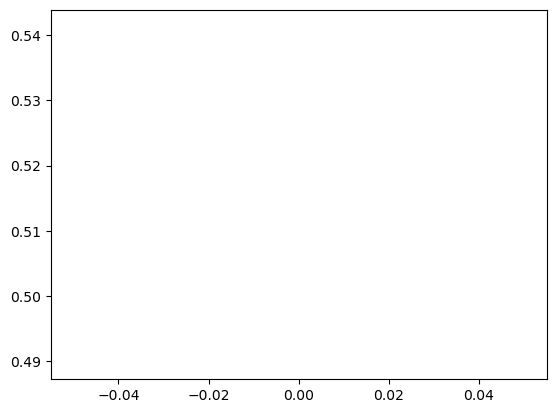

In [56]:
plt.plot(lossi)

What happened here?

The loss at the begining was greater than 25 which is even worse than the model which gives equal probability to all the characters (i.e the loss should not be more than torch.log(1/27))

## Why is this the case?
 This happened because the initialization of the matrices involved were randomly initialized and probably not to a good start which gave more importance to some characters while no importance to other characters


In [57]:
logits[0]

tensor([ 0.0191,  0.0314,  0.0770, -0.0270, -0.1545, -0.1376,  0.1635,  0.1445,
         0.2293,  0.0147, -0.0940,  0.1007,  0.0837, -0.1165, -0.0098,  0.0976,
         0.0564,  0.1131,  0.1613, -0.2135, -0.1468,  0.0849, -0.1611, -0.1233,
        -0.0846,  0.0916, -0.0403], grad_fn=<SelectBackward0>)

### What if we changed the initialization and made it all 0's?
This can work but thenc we need to check the plot of loss values.
(Hint: They will oscillate more  Why though?)
What's happening was the weights and the logits are squashed in the neural network optimization which allows them to take low values and hence oscillation

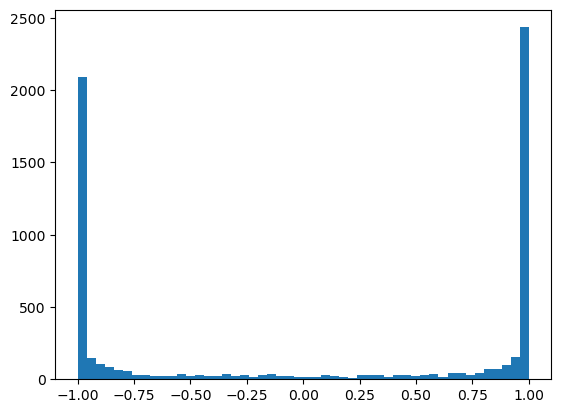

In [58]:
plt.hist(h.view(-1).tolist(),50);

The above trend is worrying recall that in the case of micrograd the backprop for tanh is (1-t**2)*gradient

Since the values are between 0 and 1 then the gradirnt is 0. So what would it mean? -> This means that the all the neurons are dead and does not fire for that particular input
the neuron is dead or for inputs where weights are biases combine to a value in a flat region in tanh this neuron would be a dead one

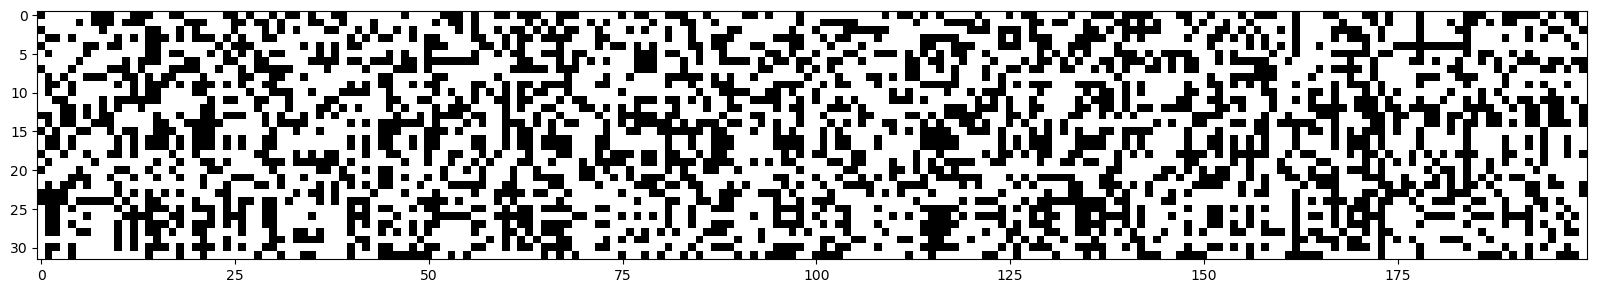

In [59]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray",interpolation="nearest")

To verify why we multiply the weights and neuron values with 0.2

As you can see the variation in Y is very high, we would want this to be close to 1.

## So how would we initialize it so that the standard deviation is close to 1
The correct answer is we divide by square root of the elements in this case 10 (Fan-in)

tensor(-0.0093) tensor(0.9957)
tensor(-0.0004) tensor(0.9759)


(array([4.55849056e-05, 6.83773585e-05, 0.00000000e+00, 4.55849056e-05,
        4.55849056e-05, 9.11698113e-05, 3.41886792e-04, 7.52150943e-04,
        1.32196226e-03, 2.02852830e-03, 4.19381132e-03, 6.76935849e-03,
        1.09403774e-02, 1.82795472e-02, 2.80803019e-02, 4.37159245e-02,
        6.42519245e-02, 9.22182641e-02, 1.30236075e-01, 1.80356679e-01,
        2.37953207e-01, 3.03618264e-01, 3.63152151e-01, 4.07050415e-01,
        4.31643471e-01, 4.28019471e-01, 4.04269736e-01, 3.47083471e-01,
        2.85293132e-01, 2.25462943e-01, 1.72584453e-01, 1.24674717e-01,
        8.51526037e-02, 5.70950943e-02, 3.76531321e-02, 2.53907924e-02,
        1.53393207e-02, 9.73237735e-03, 5.35622641e-03, 3.30490566e-03,
        2.09690566e-03, 1.36754717e-03, 7.06566037e-04, 4.10264151e-04,
        1.13962264e-04, 6.83773585e-05, 6.83773585e-05, 0.00000000e+00,
        0.00000000e+00, 4.55849056e-05]),
 array([-5.45966864, -5.24029778, -5.02092691, -4.80155605, -4.58218519,
        -4.36281433, 

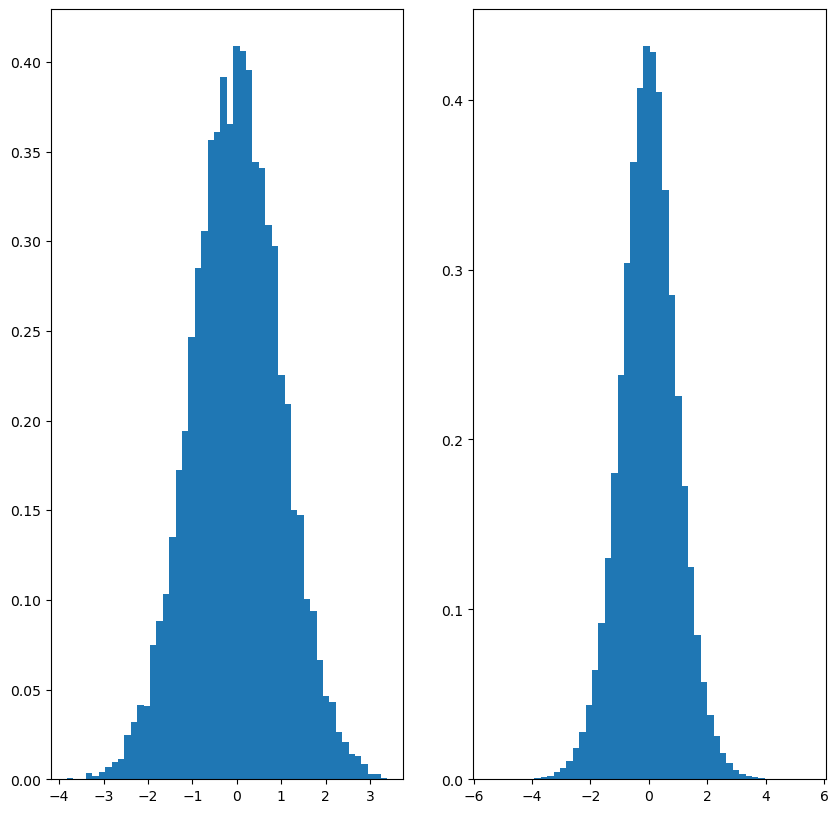

In [60]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize= (10,10))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50, density=True)

## So how should we initialize a neural network -> initialize it with Kaiming initilialization
However tricks like Normalization and batchnorm can help in allowing large(deep) networks to counteract this flaw and prevent vanishing gradient -> also residual connections

Batch normalization allowed deep networks to be trained effectively and also took care of vanishing gradient

In [72]:
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = (
    torch.randn((n_embd * block_size, n_hidden), generator=g)
    * (5 / 3)
    / ((n_embd * block_size) ** 0.5)
)  # * 0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


### Why do we need batch norm statistics to be in a running fashion?
This is because while caluculating the normalization parameters (mean and std deviation) we calculate it based on the batch

### What about the biases?
We don't need to add the biases since they will be substracted while calculating the mean ans std.

In [78]:
batch_size = 32
max_steps = 200000
lossi = []
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb]
    emb = emb.view(emb.shape[0], -1)
    hpreact = emb @ W1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 2.3626
  10000/ 200000: 2.0869
  20000/ 200000: 2.1146
  30000/ 200000: 2.5826
  40000/ 200000: 1.8981
  50000/ 200000: 2.3935
  60000/ 200000: 1.9886
  70000/ 200000: 2.0487
  80000/ 200000: 2.1445
  90000/ 200000: 2.1670
 100000/ 200000: 2.2222
 110000/ 200000: 1.6968
 120000/ 200000: 2.0963
 130000/ 200000: 1.8935
 140000/ 200000: 2.7190
 150000/ 200000: 2.0643
 160000/ 200000: 1.9319
 170000/ 200000: 2.6357
 180000/ 200000: 1.9264
 190000/ 200000: 2.0882


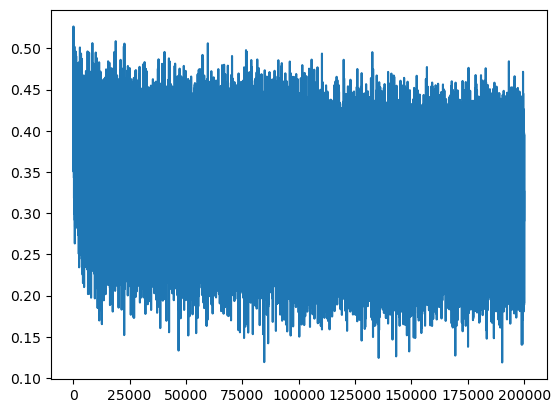

In [74]:
plt.plot(lossi)

In [76]:
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1  # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [77]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1  # + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.4602200984954834
val 2.5015251636505127


#### Why do we need tanh anyway?
Indeed if we can stabilize the linear weights to have a gain of 1, then ideally all the linear layers will have good activation and gradients so why do this?
Turns out that just stacking the neural network comprising of linear layers will reduce its expressive power. Its just one linear layer in the end
 Example equation: $$Wx+b = W^L x +b_L + W^{L-1}x + b_{L-1} + ..$$

In [92]:

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
# layers = [
#     Linear(n_embd * block_size, n_hidden, bias=False),
#     BatchNorm1d(n_hidden),
#     Tanh(),
#     Linear(n_hidden, n_hidden, bias=False),
#     BatchNorm1d(n_hidden),
#     Tanh(),
#     Linear(n_hidden, n_hidden, bias=False),
#     BatchNorm1d(n_hidden),
#     Tanh(),
#     Linear(n_hidden, n_hidden, bias=False),
#     BatchNorm1d(n_hidden),
#     Tanh(),
#     Linear(n_hidden, n_hidden, bias=False),
#     BatchNorm1d(n_hidden),
#     Tanh(),
#     Linear(n_hidden, vocab_size, bias=False),
#     BatchNorm1d(vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    #layers[-1].gamma *= 0.1
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


#### In the above code why do we need to add gain? 
Turns out that linear layer will try to spread and tanh activation will try to squash the values when adding the values become to large or small
In order to avoid this we multiply the linear layer by gain (refer to kaiming and he)

In [93]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )

    if i >= 1000:
        break

      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

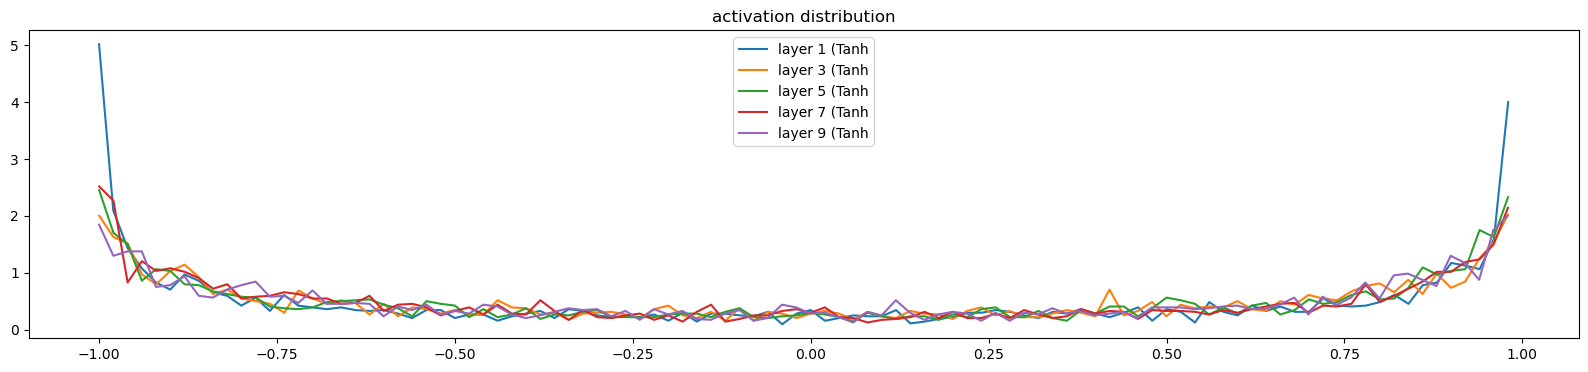

In [95]:
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(
            "layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%"
            % (
                i,
                layer.__class__.__name__,
                t.mean(),
                t.std(),
                (t.abs() > 0.97).float().mean() * 100,
            )
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution")

layer 1 (      Tanh): mean +0.000024, std 3.353991e-03
layer 3 (      Tanh): mean +0.000012, std 3.157344e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

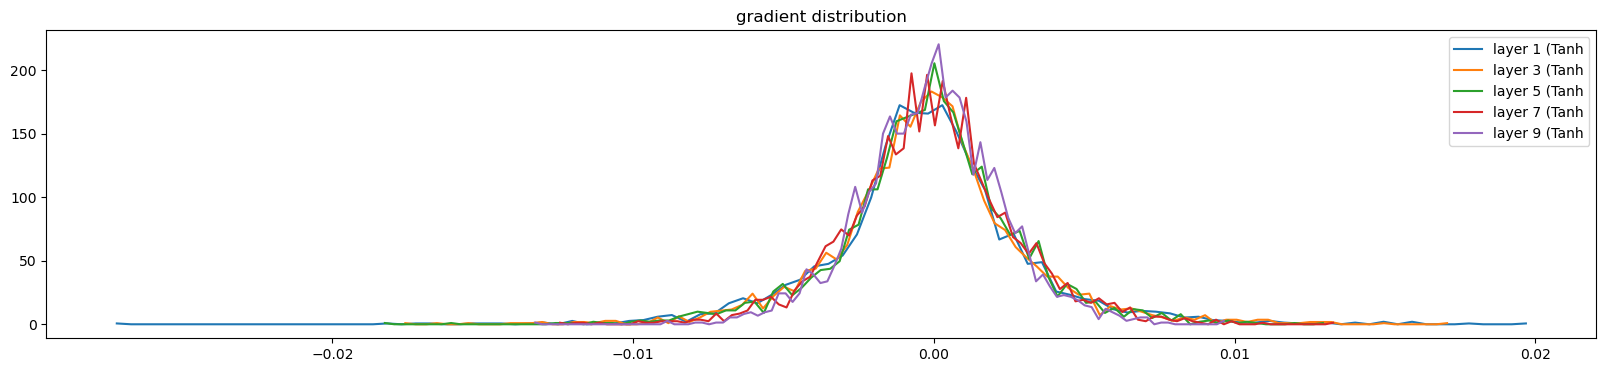

In [96]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(
            "layer %d (%10s): mean %+f, std %e"
            % (i, layer.__class__.__name__, t.mean(), t.std())
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

#### Visualize the histogram and check the gradient to date ratio

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005290e-02 | grad:data ratio 3.214555e-02
weight (100, 100) | mean +0.000033 | std 7.821212e-03 | grad:data ratio 4.653362e-02
weight (100, 100) | mean -0.000107 | std 6.655621e-03 | grad:data ratio 3.925852e-02
weight (100, 100) | mean -0.000017 | std 6.086040e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean +0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


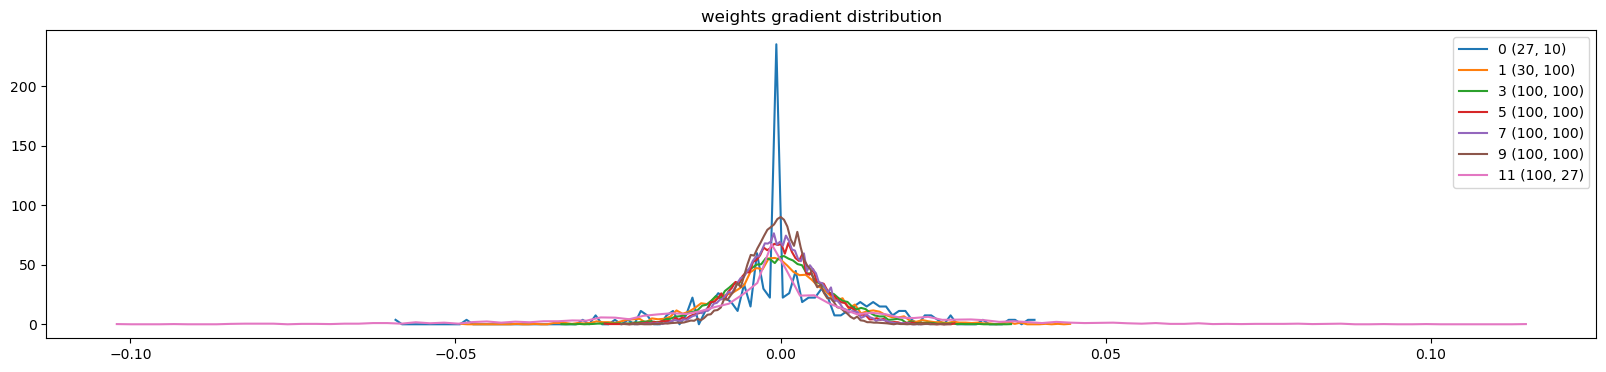

In [98]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [103]:
len(ud)

1001

The data to update plot which measures how great the updates are to the data

From the below diagram we can see that the last layer gets updated too long and this poses a problem

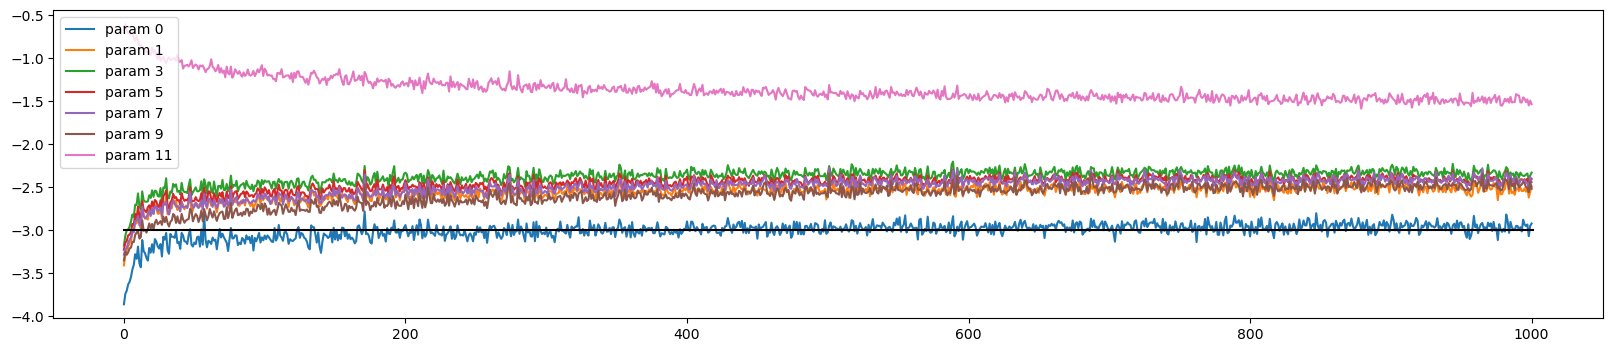

In [102]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)